In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
plt.style.available
plt.style.use('classic')

In [2]:
# 查找matplotlib支持的系统字体
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts()

In [3]:
# 读取数据，看下数据分布情况

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

猜测可能与Survived相关的特征：

* Pclass - 乘客等级：关联到乘客的财富、社会地位等属性，可能会作为Survived考虑的因素。
* Sex - 性别：强相关特征，因在沉船时，船长说了，『lady and kid first！』
* Age - 年龄：中度相关，年龄字段可以筛选出老人小孩，年轻女人等，可以作为参考
* SibSp - 兄弟/姊妹数：中度相关，可能会作为当事人考虑的因素
* Parch - 父母/小孩数：中度相关，同上
* Ticket - 船票信息：弱特征，待查看
* Fare - 票价：可能是中度相关特征，和Age特征一样
* Cabin - 船舱号：有船舱号的，票价会贵很多，可作为参考因素
* Embarked - 登船港口：可能与Pclass字段存在关联，待验证

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


从以上可以看到，数据并不是完整的，而是存在缺失值的，数据类型有文本型字符串，整型和浮点型。

对于离散型的数据的处理，我们需要对其进行LabelEncoder或者One-hot Encoder，让计算机能够识别每个字段的类别。

而对于连续性的数据，主要是针对缺失值的处理。而缺失值的处理方法一般有以下几种：

* 存在大量缺失值的样本，一般就不能使用了，该样本不具备用于预测的完整性要求，且可能会带入噪声数据，反而影响最后的预测结果；
* 存在部分的缺失值的情况，对于离散型的类别数据，我们可以将缺失值的NaN的数据单独作为一个类别，加入特征。或者也可以将其补充上，比如使用无缺失值的特征训练出模型填充上存在缺失值数据该部分特征；
* 而存在部分缺失值的连续值的处理，思路也跟离散型差不多，只是，我们会将连续值离散化，也就是分桶的思想，特别用于类别划分时，比如在树模型中的属性划分；
* 存在少量的缺失值的情况，我们一般会采用缺失值填充的方法，比如填充均值、中位数、众数、拉格朗日插值，或使用机器学习训练出模型来填充。

以上存在缺失值的字段有，Age字段 - 可以采用模型训练填充法；Cabin字段 - 缺失值被视为无船舱号处理；Embarked字段 - 也可以采用模型训练法填充。

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从上面的数据分布可以看出如下：

* Survived字段：最后的生还率为0.38
* Pclass字段：我们看分为区间，从min到max，1等乘客数明显要少于2/3等乘客数
* Age字段：乘客的平均年龄在29岁，同时，我们可以看下min最小值为0.42的乘客，是不是婴儿？
* SibSp字段：约有一半的人都有兄弟姊妹
* SibSp字段：约有1/3多的人父母健在，或有小孩
* Fare字段：船票的价格，从min到max，可以筛选最小船票价格的乘客

In [8]:
train[train['Age'] == 0.42] # 可能是婴儿

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C


In [9]:
# train[train['Fare'] <= 10]

In [10]:
# train[train['Cabin'].isnull()].sort_values('Fare', ascending=False)

我们看到大部分没有船舱号的乘客的票价都较低，而某些票价高的乘客也没有船舱号，而票价低的乘客却有船舱号，试猜想，试试在沉船时，互相认识的人，或者之前不认识，但是而后为了让其活下去，而互换了船票呢！我们看下这些人是否得救呢？

In [11]:
Cabin = train[train['Fare'] <= 10]
Cabin[Cabin['Cabin'].notnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.65,F G73,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.00,B94,S
429,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.05,E10,S
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.65,F G63,S
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.65,F G73,S
776,777,0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.75,F38,Q
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.00,A36,S
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.00,B102,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.00,B51 B53 B55,S


看来并不是啊！！！再看看呢~~

In [12]:
Cabin[Cabin['Survived'] == 1]['Sex'].value_counts()

female    38
male      29
Name: Sex, dtype: int64

得救的这部分人大多是女性！好了言归正传，我们来详细分析一下！！

Text(0.5,1,'各登船口岸上船人数 - 图5')

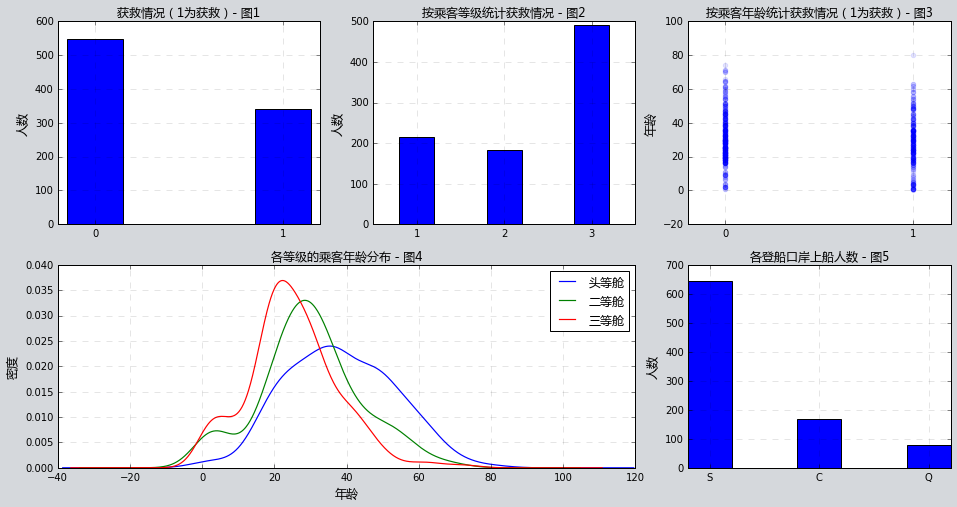

In [13]:
from matplotlib.font_manager import FontProperties

font = FontProperties(family='sans-serif', 
                      fname='/Users/johnnie/Library/Fonts/Microsoft YaHei.ttf', 
                      style='italic', weight='bold', size='large')

fig = plt.figure(figsize=(16, 8), facecolor='#D5D8DC')

# 获救情况
plt.subplot2grid((2, 3), (0, 0))
survived = train['Survived'].value_counts()
plt.bar(survived.index, survived.values,
        width=0.3, color='blue',
        align='center')
plt.xticks(np.arange(2))
plt.grid(linestyle='dashed', alpha=0.2)
plt.ylabel('人数', fontproperties=font)
plt.title('获救情况（1为获救）- 图1', fontproperties=font)

# 乘客等级分布
plt.subplot2grid((2, 3), (0, 1))
pclass = train[train['Pclass'].notnull()]['Pclass'].value_counts()
plt.bar(pclass.index, pclass.values,
        width=0.4, color='blue',
        align='center')
plt.xticks(np.arange(1, 4))
plt.grid(linestyle='dashed', alpha=0.2)
plt.ylabel('人数', fontproperties=font)
plt.title('按乘客等级统计获救情况 - 图2', fontproperties=font)

# 按乘客年龄统计获救情况 - 注意不要把简单事情复杂化
plt.subplot2grid((2, 3), (0, 2))
survived_by_age = train[train['Age'].notnull()]
plt.scatter(survived_by_age['Survived'], survived_by_age['Age'], color='blue', alpha=0.1)
plt.xticks(np.arange(0, 2))
plt.grid(linestyle='dashed', alpha=0.2)
plt.ylabel('年龄', fontproperties=font)
plt.title('按乘客年龄统计获救情况（1为获救）- 图3', fontproperties=font)

# 各等级的乘客年龄分布
plt.subplot2grid((2, 3), (1, 0), colspan=2)
pclass1_by_age = survived_by_age[survived_by_age.Pclass == 1]
pclass2_by_age = survived_by_age[survived_by_age.Pclass == 2]
pclass3_by_age = survived_by_age[survived_by_age.Pclass == 3]
pclass1_by_age.Age.plot(kind='kde', linewidth=1.2)
pclass2_by_age.Age.plot(kind='kde', linewidth=1.2)
pclass3_by_age.Age.plot(kind='kde', linewidth=1.2)
plt.xlabel('年龄', fontproperties=font)
plt.ylabel('密度', fontproperties=font)
plt.grid(linestyle='dashed', alpha=0.2)
plt.legend(['头等舱', '二等舱', '三等舱'], prop=font)
plt.title('各等级的乘客年龄分布 - 图4', fontproperties=font)

# 各登船口岸上船人数
plt.subplot2grid((2, 3), (1, 2))
embarked = train[train['Embarked'].notnull()]['Embarked'].value_counts()
plt.bar(embarked.index, embarked.values,
        width=0.4, color='blue',
        align='center')
plt.grid(linestyle='dashed', alpha=0.2)
plt.ylabel('人数', fontproperties=font)
plt.title('各登船口岸上船人数 - 图5', fontproperties=font)

* 图2验证了我们看到的数据分布情况，2/3等乘客数明显多于1等乘客数；
* 图3中的获救和未获救乘客的年龄分布都比较均匀，并没有明显的特点，比如说获救的年龄较小的多！不过，注意到没，获救乘客最上面有一个80岁的老人，我们可以看下这位乘客的情况！
* 图4中不同舱位的乘客年龄分布也比较有意思，头等舱的乘客平均年龄接近40岁，而2/3等舱的年龄就相对较小，大概20-30岁之间，这也比较符合不同年龄层次的消费能力，哈哈！！

In [14]:
survived_by_age[survived_by_age.Age > 75] # 原来是位老爷爷！
# 关于他的信息：
# https://www.encyclopedia-titanica.org/titanic-survivor/algernon-barkworth.html
# https://www.wikitree.com/wiki/Barkworth-2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S


这个时候我们可能会想到：

* 不同等级/登船港口的乘客可能会影响后面的是否生还！
* 不同年龄也可能是决策因素
* 另外不知道登船口岸是否有关

我们一一来分析下~~

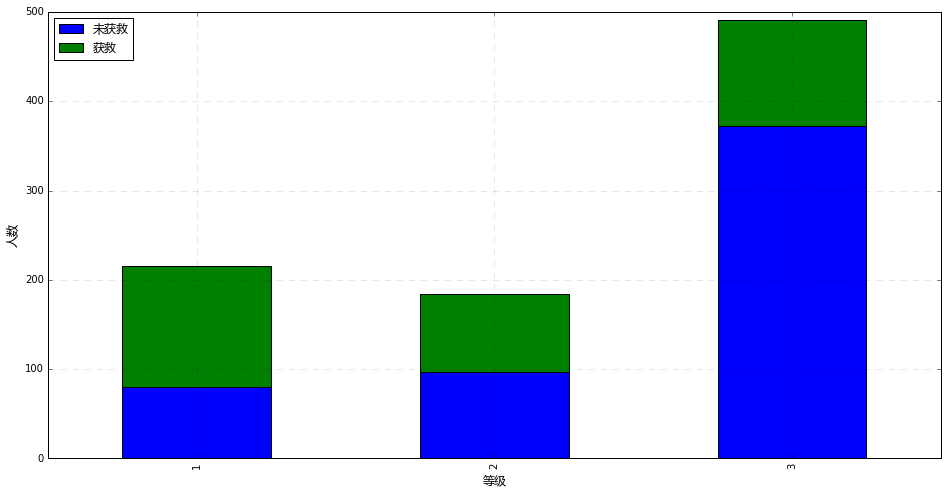

In [15]:
# 乘客等级与是否获救分析

survived_by_pclass = train[train.Pclass.notnull()]
survived_by_pclass_0 = pd.DataFrame(survived_by_pclass[survived_by_pclass.Survived == 0].Pclass.value_counts().values,
                                    index=survived_by_pclass[survived_by_pclass.Survived == 0].Pclass.value_counts().index,
                                    columns=['未获救'])
survived_by_pclass_1 = pd.DataFrame(survived_by_pclass[survived_by_pclass.Survived == 1].Pclass.value_counts().values,
                                    index=survived_by_pclass[survived_by_pclass.Survived == 1].Pclass.value_counts().index,
                                    columns=['获救'])
survived_by_pclass_count = survived_by_pclass_0.merge(survived_by_pclass_1, left_index=True, right_index=True)
survived_by_pclass_count.sort_index(inplace=True, ascending=True)
survived_by_pclass_count.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.grid(linestyle='dashed', alpha=0.2)
plt.xlabel('等级', fontproperties=font)
plt.ylabel('人数', fontproperties=font)
plt.legend(['未获救', '获救'], loc='best', prop=font)

In [16]:
survived_by_pclass_count['获救率'] = survived_by_pclass_count['获救'] / (survived_by_pclass_count['获救'] + survived_by_pclass_count['未获救'])
survived_by_pclass_count

,未获救,获救,获救率
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


无论从图表中，还是确证的数据来看，都是等级越高，获救率也就越高，果然是那啥的~~

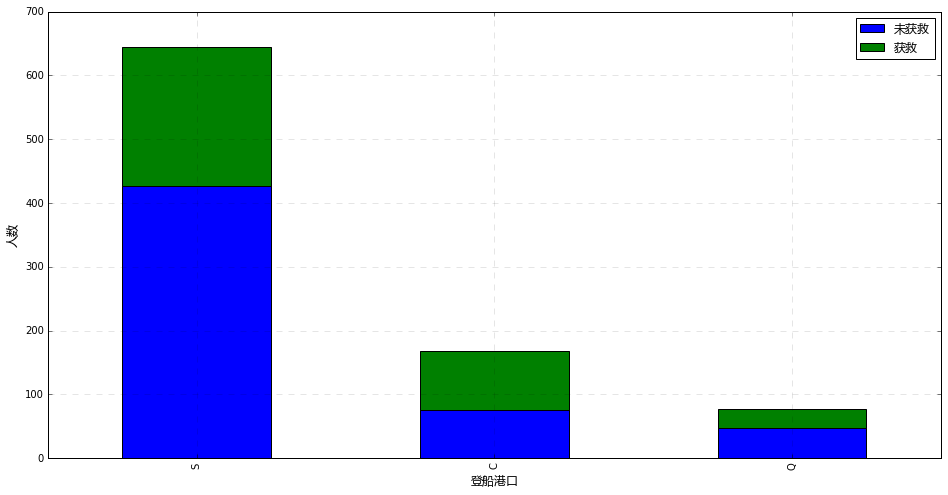

In [17]:
# 登录港口与是否获救分析

survived_by_embarked = train[train.Embarked.notnull()]
survived_by_embarked_0 = pd.DataFrame(survived_by_embarked[survived_by_embarked.Survived == 0].Embarked.value_counts().values,
                                    index=survived_by_embarked[survived_by_embarked.Survived == 0].Embarked.value_counts().index,
                                    columns=['未获救'])
survived_by_embarked_1 = pd.DataFrame(survived_by_embarked[survived_by_embarked.Survived == 1].Embarked.value_counts().values,
                                    index=survived_by_embarked[survived_by_embarked.Survived == 1].Embarked.value_counts().index,
                                    columns=['获救'])
survived_by_embarked_count = survived_by_embarked_0.merge(survived_by_embarked_1, left_index=True, right_index=True)
survived_by_embarked_count.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.grid(linestyle='dashed', alpha=0.2)
plt.xlabel('登船港口', fontproperties=font)
plt.ylabel('人数', fontproperties=font)
plt.legend(['未获救', '获救'], loc='best', prop=font)

In [18]:
survived_by_embarked_count['获救率'] = survived_by_embarked_count['获救'] / (survived_by_embarked_count['获救'] + survived_by_embarked_count['未获救'])
survived_by_embarked_count

,未获救,获救,获救率
S,427,217,0.336957
C,75,93,0.553571
Q,47,30,0.389610


C港口可能对应一等乘客身份，Q为二等乘客，S为三等乘客，也是C > Q > S。以上我们得到Pclass和Embarked，均为有效特征。

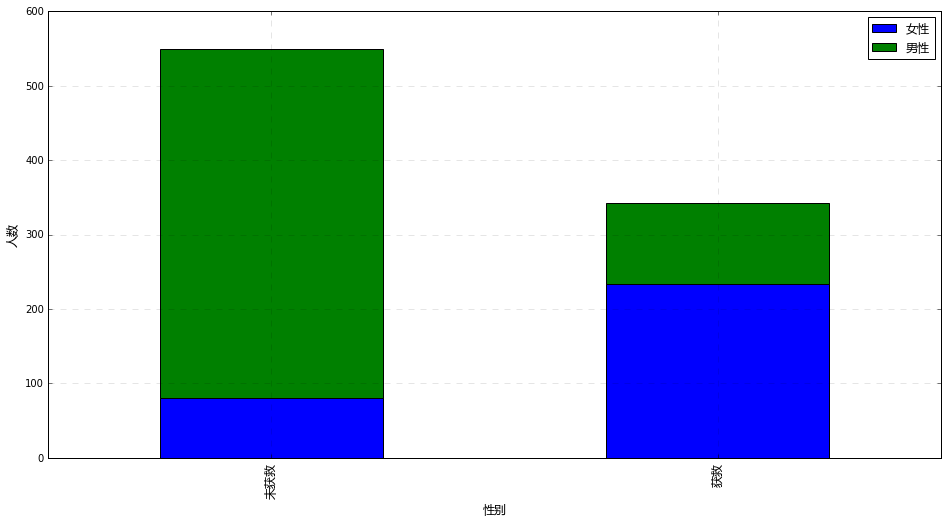

In [19]:
# 再看下性别特征是否有关

survived_by_sex = train[train.Sex.notnull()]
survived_by_sex_0 = pd.DataFrame(survived_by_sex[survived_by_sex.Survived == 0].Sex.value_counts().values,
                                    index=survived_by_sex[survived_by_sex.Survived == 0].Sex.value_counts().index,
                                    columns=['未获救'])
survived_by_sex_1 = pd.DataFrame(survived_by_sex[survived_by_sex.Survived == 1].Sex.value_counts().values,
                                    index=survived_by_sex[survived_by_sex.Survived == 1].Sex.value_counts().index,
                                    columns=['获救'])
survived_by_sex_count = pd.concat([survived_by_sex_0.T, survived_by_sex_1.T])
survived_by_sex_count.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.grid(linestyle='dashed', alpha=0.2)
plt.xticks(np.arange(0, 2), ('未获救', '获救'), fontproperties=font)
plt.xlabel('性别', fontproperties=font)
plt.ylabel('人数', fontproperties=font)
plt.legend(['女性', '男性'], loc='best', prop=font)

In [20]:
survived_by_sex_count.loc[['获救']] / survived_by_sex_count.sum()

,female,male
获救,0.742038,0.188908


从图表和数据都证实了女生的生还率要高于男性，毕竟女性是孕育生命的摇篮！！

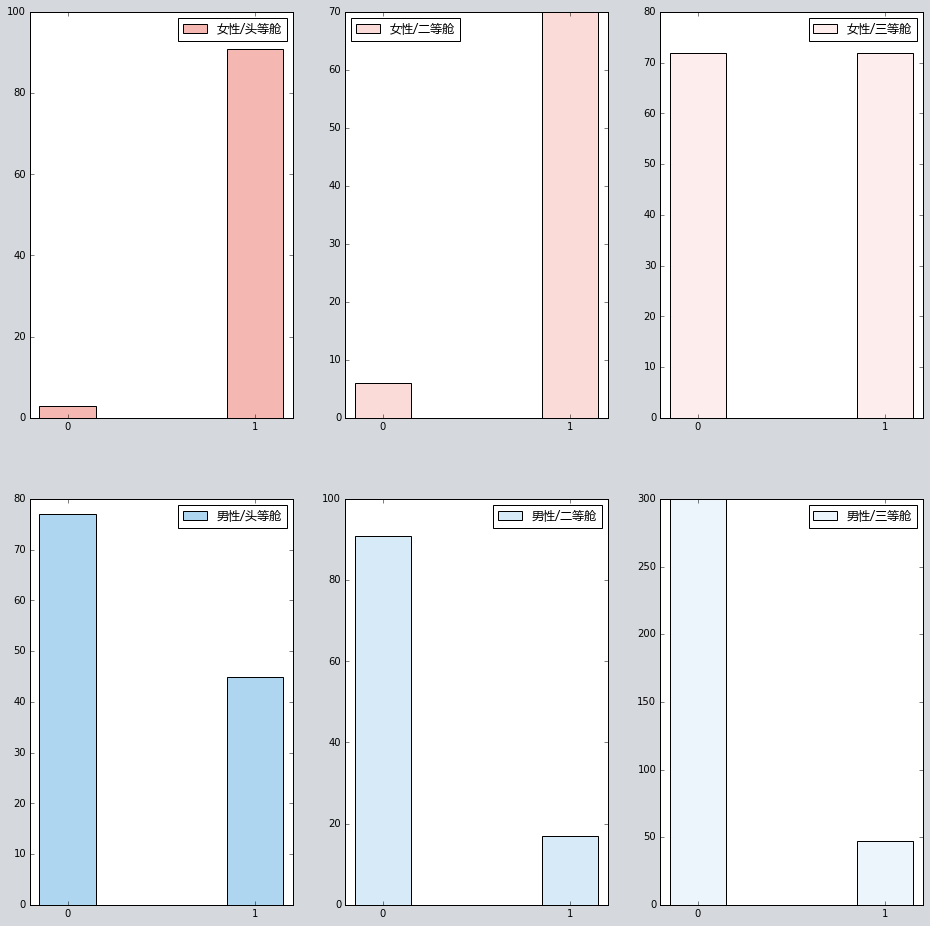

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(16, 16), facecolor='#D5D8DC')

survived_by_sex_and_pclass = pd.DataFrame(train.groupby(['Survived', 'Sex', 'Pclass']).PassengerId.count())
survived_by_sex_and_pclass.reset_index(inplace=True)
survived_by_female_and_pclass1 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'female') & (survived_by_sex_and_pclass.Pclass == 1)]
survived_by_female_and_pclass2 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'female') & (survived_by_sex_and_pclass.Pclass == 2)]
survived_by_female_and_pclass3 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'female') & (survived_by_sex_and_pclass.Pclass == 3)]
survived_by_male_and_pclass1 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'male') & (survived_by_sex_and_pclass.Pclass == 1)]
survived_by_male_and_pclass2 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'male') & (survived_by_sex_and_pclass.Pclass == 2)]
survived_by_male_and_pclass3 = survived_by_sex_and_pclass[(survived_by_sex_and_pclass.Sex == 'male') & (survived_by_sex_and_pclass.Pclass == 3)]

axes[0, 0].bar(survived_by_female_and_pclass1.Survived, survived_by_female_and_pclass1.PassengerId, width=0.3, align='center', color='#F5B7B1')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].legend(['女性/头等舱'], prop=font, loc='best')
axes[0, 1].bar(survived_by_female_and_pclass2.Survived, survived_by_female_and_pclass2.PassengerId, width=0.3, align='center', color='#FADBD8')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].legend(['女性/二等舱'], prop=font, loc='best')
axes[0, 2].bar(survived_by_female_and_pclass3.Survived, survived_by_female_and_pclass3.PassengerId, width=0.3, align='center', color='#FDEDEC')
axes[0, 2].set_xticks([0, 1])
axes[0, 2].legend(['女性/三等舱'], prop=font, loc='best')
axes[1, 0].bar(survived_by_male_and_pclass1.Survived, survived_by_male_and_pclass1.PassengerId, width=0.3, align='center', color='#AED6F1')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].legend(['男性/头等舱'], prop=font, loc='best')
axes[1, 1].bar(survived_by_male_and_pclass2.Survived, survived_by_male_and_pclass2.PassengerId, width=0.3, align='center', color='#D6EAF8')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].legend(['男性/二等舱'], prop=font, loc='best')
axes[1, 2].bar(survived_by_male_and_pclass3.Survived, survived_by_male_and_pclass3.PassengerId, width=0.3, align='center', color='#EBF5FB')
axes[1, 2].legend(['男性/三等舱'], prop=font, loc='best')
axes[1, 2].set_xticks([0, 1])

我们再来看下SibSp字段和Parch字段，或许会有关！

In [22]:
# 验证SibSp字段是否与Survived存在关联

survived_by_sibsp = train[train.SibSp.notnull()]
survived_by_sibsp_count = pd.DataFrame(survived_by_sibsp.groupby(['SibSp', 'Survived'])['PassengerId'].count())
survived_by_sibsp_count.reset_index(inplace=True)
survived_by_sibsp_count_0 = survived_by_sibsp_count[0:10:2]
survived_by_sibsp_count_0.reset_index(inplace=True, drop=True)
survived_by_sibsp_count_1 = survived_by_sibsp_count[1:10:2]
survived_by_sibsp_count_1.reset_index(inplace=True, drop=True)
survived_by_sibsp_count_0_partial = survived_by_sibsp_count[10:]
survived_by_sibsp_count_0_partial.reset_index(inplace=True, drop=True)
survived_by_sibsp_count_1_partial = pd.DataFrame({'SibSp': [5, 8],
                                                 'Survived': [1, 1],
                                                 'PassengerId': [0, 0]}, columns=['SibSp', 'Survived', 'PassengerId'])
survived_by_sibsp_count_1_partial.reset_index(inplace=True, drop=True)
survived_by_sibsp_count_01 = pd.concat([survived_by_sibsp_count_0, survived_by_sibsp_count_1], axis=1)
survived_by_sibsp_count_01_partial = pd.concat([survived_by_sibsp_count_0_partial, survived_by_sibsp_count_1_partial], axis=1)
survived_by_sibsp_count_rate = pd.concat([survived_by_sibsp_count_01, survived_by_sibsp_count_01_partial], ignore_index=True)
survived_by_sibsp_count_rate.columns = ['SibSp_0', 'Survived_0', 'PassengerId_0', 'SibSp_1', 'Survived_1', 'PassengerId_1']
survived_by_sibsp_count_rate['survivedRate'] = survived_by_sibsp_count_rate.PassengerId_1 / (survived_by_sibsp_count_rate.PassengerId_1 + survived_by_sibsp_count_rate.PassengerId_0)
survived_by_sibsp_count_rate

,SibSp_0,Survived_0,PassengerId_0,SibSp_1,Survived_1,PassengerId_1,survivedRate
0,0,0,398,0,1,210,0.345395
1,1,0,97,1,1,112,0.535885
2,2,0,15,2,1,13,0.464286
3,3,0,12,3,1,4,0.250000
4,4,0,15,4,1,3,0.166667
5,5,0,5,5,1,0,0.000000
6,8,0,7,8,1,0,0.000000


从以上数据我们可以看到，没有兄弟姊妹的，也就是说独生子的，生还率有点低，可能当时也没有选择，也可能是无牵无挂，更可能迫不得已，我们等下可以看下这部分数据的是否父母健在，是否有孩子！

而对于有兄弟姊妹的，随着人数增多，生还率也在下降，这就说明某种程度上存在选择关系，有多个的，在当下可能会选择谁“活下来”！如果兄弟姊妹越多，他自己的生还率就变低了！

In [23]:
survived_by_sibsp[survived_by_sibsp.SibSp == 0]['Parch'].value_counts()

0    537
1     38
2     29
5      2
4      1
3      1
Name: Parch, dtype: int64

可以看到是独生子的乘客，大部分也是无父母和小孩，还是还是挺悲惨的！

In [24]:
# 再来分析下Parch字段

survived_by_parch = train[train.Parch.notnull()]
survived_by_parch_count = pd.DataFrame(survived_by_parch.groupby(['Parch', 'Survived'])['PassengerId'].count())
survived_by_parch_count.reset_index(inplace=True)
survived_by_parch_count_0 = survived_by_parch_count.loc[[0, 2, 4, 6, 9]]
survived_by_parch_count_0.reset_index(inplace=True, drop=True)
survived_by_parch_count_1 = survived_by_parch_count.loc[[1, 3, 5, 7, 10]]
survived_by_parch_count_1.reset_index(inplace=True, drop=True)
survived_by_parch_count_0_partial = survived_by_parch_count.loc[[8, 11]]
survived_by_parch_count_0_partial.reset_index(inplace=True, drop=True)
survived_by_parch_count_01 = pd.concat([survived_by_parch_count_0, survived_by_parch_count_1], axis=1)
survived_by_parch_count_1_partial = pd.DataFrame({'Parch': [4, 6],
                                                 'Survived': [1, 1],
                                                 'PassengerId': [0, 0]},
                                                columns=['Parch', 'Survived', 'PassengerId'])
survived_by_parch_count_01_partial = pd.concat([survived_by_parch_count_0_partial, survived_by_parch_count_1_partial], axis=1)
survived_by_parch_count_rate = pd.concat([survived_by_parch_count_01, survived_by_parch_count_01_partial], ignore_index=True)
survived_by_parch_count_rate.columns = ['Parch_0', 'Survived_0', 'PassengerId_0', 'Parch_1', 'Survived_1', 'PassengerId_1']
survived_by_parch_count_rate['survivedRate'] = survived_by_parch_count_rate.PassengerId_1 / (survived_by_parch_count_rate.PassengerId_1 + survived_by_sibsp_count_rate.PassengerId_0)
survived_by_parch_count_rate

,Parch_0,Survived_0,PassengerId_0,Parch_1,Survived_1,PassengerId_1,survivedRate
0,0,0,445,0,1,233,0.369255
1,1,0,53,1,1,65,0.401235
2,2,0,40,2,1,40,0.727273
3,3,0,2,3,1,3,0.200000
4,5,0,4,5,1,1,0.062500
5,4,0,4,4,1,0,0.000000
6,6,0,1,6,1,0,0.000000


父母不在或没有小孩的生环率较低，与前面的SibSp字段对应；家里的人越多，生还率直线下降，与SibSp类似！

到此我们看下，Sex字段，Pclass和Embarked字段都是强相关特征，SibSp和Parch字段是中度相关特征。

Ticket字段，为船票信息，应该与Survived字段关系不大！我们来看下Cabin字段，这个字段缺失值太多，我们可以看下有无缺失对于Survived的影响！

In [25]:
# train.Cabin.value_counts()

ABCD可能是甲板编号，后面的数字可能是用于区分不同乘客的，maybe是房间号。这个类目过于分散，如果one-hot encoder后，特征会很多，每个新特征是否与Survived相关，还不一定！？我们可以先看下Cabin有无与Survived的情况...

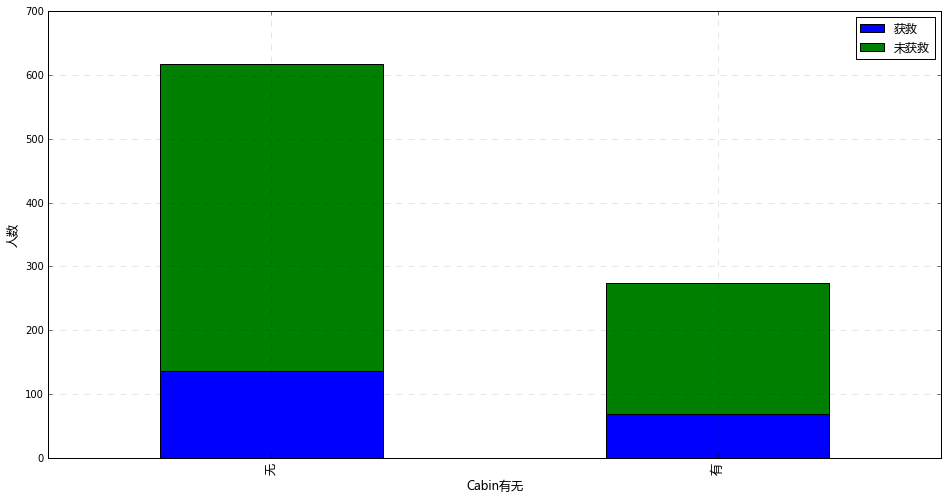

In [26]:
survived_by_cabin_notnull = train[train.Cabin.notnull()]
survived_by_cabin_isnull = train[train.Cabin.isnull()]
survived_by_cabin_notnull_count = pd.DataFrame(survived_by_cabin_notnull.Survived.value_counts())
survived_by_cabin_notnull_count.reset_index(inplace=True, drop=True)
survived_by_cabin_isnull_count = pd.DataFrame(survived_by_cabin_isnull.Survived.value_counts())
survived_by_cabin_isnull_count.reset_index(inplace=True, drop=True)

survived_by_cabin_count = pd.concat([survived_by_cabin_notnull_count, survived_by_cabin_isnull_count], axis=1)
survived_by_cabin_count.columns = ['有', '无']
survived_by_cabin_count.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.grid(linestyle='dashed', alpha=0.2)
plt.xticks(np.arange(0, 2), ('无', '有'), fontproperties=font)
plt.xlabel('Cabin有无', fontproperties=font)
plt.ylabel('人数', fontproperties=font)
plt.legend(['获救', '未获救'], loc='best', prop=font)

In [27]:
survived_by_cabin_count_rate = survived_by_cabin_count.T
survived_by_cabin_count_rate['survivedRate'] = survived_by_cabin_count_rate[1] / (survived_by_cabin_count_rate[0] + survived_by_cabin_count_rate[1])
survived_by_cabin_count_rate

,0,1,survivedRate
有,136,68,0.333333
无,481,206,0.299854


显然有房间号的乘客的生还率要稍高于无房间号的乘客！按照这种思路，我们先把Cabin字段分为两类，Yes和No...

In [28]:
train.loc[(train.Cabin.notnull()), 'Cabin'] = 'Yes'

In [29]:
train.loc[(train.Cabin.isnull()), 'Cabin'] = 'No'

In [30]:
train.Cabin.value_counts()

No     687
Yes    204
Name: Cabin, dtype: int64

In [31]:
# 使用交叉验证来评估模型

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

def cross_validate_score_for_discrete_values(estimator, trainingData, test_size, random_state=0):
    le = LabelEncoder()
    splite_train, splite_test = train_test_split(trainingData, test_size=test_size, random_state=random_state)
    X_splite_train = splite_train.as_matrix()[:, :-1]
    X_splite_test = splite_test.as_matrix()[:, :-1]
    y_splite_train = le.fit_transform(splite_train.as_matrix()[:, -1])
    y_splite_test = le.fit_transform(splite_test.as_matrix()[:, -1])
    estimator.fit(X_splite_train, y_splite_train)
    predictResult = estimator.predict(X_splite_test)
    val_score = estimator.score(X_splite_test, y_splite_test)
    return val_score, predictResult, y_splite_test

def cross_validate_score_for_continuous_values(estimator, trainingData, test_size, random_state=0):
    splite_train, splite_test = train_test_split(trainingData, test_size=test_size, random_state=random_state)
    X_splite_train = splite_train.as_matrix()[:, :-1]
    X_splite_test = splite_test.as_matrix()[:, :-1]
    y_splite_train = splite_train.as_matrix()[:, -1]
    y_splite_test = splite_test.as_matrix()[:, -1]
    estimator.fit(X_splite_train, y_splite_train)
    predictResult = estimator.predict(X_splite_test)
    val_score = estimator.score(X_splite_test, y_splite_test)
    return val_score, predictResult, y_splite_test

我们对Name字段做处理，Name字段中一般都会包含Mr、Mrs和Miss，这几个称为会与不同年龄区间相关！

In [32]:
trainNameMrs = train[train.Name.str.contains('Mrs')]
trainNameMrs.drop([199, 427], inplace=True)
trainNameMiss = train[train.Name.str.contains('Miss')]
trainNameMr = train[(train.Name.str.contains('Mr')) & (train.Name.str.contains('Mrs') == False)]
trainNamenotMrsMrMiss = train[(train.Name.str.contains('Mr') == False) & 
                              (train.Name.str.contains('Miss') == False)]

trainNameMrs.loc[:].Name = 'Mrs'
trainNameMiss.loc[:].Name = 'Miss'
trainNameMr.loc[:].Name = 'Mr'
trainNamenotMrsMrMiss.loc[(trainNamenotMrsMrMiss.Sex == 'female'), 'Name'] = 'unknown'
trainNamenotMrsMrMiss.loc[(trainNamenotMrsMrMiss.Sex == 'male'), 'Name'] = 'Mr'

trainName = pd.concat([trainNameMrs, trainNameMiss, trainNameMr, trainNamenotMrsMrMiss])
trainName.sort_values('PassengerId', inplace=True)

/Users/johnnie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/johnnie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


注意：在这里有两条数据在筛选合并时，出现重复，找到他们，并将其纠正~

In [33]:
trainName[(trainName['PassengerId'] == 200) | (trainName['PassengerId'] == 428)] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199,200,0,2,Miss,female,24.0,0,0,248747,13.0,No,S
427,428,1,2,Miss,female,19.0,0,0,250655,26.0,No,S


我们注意到Name字段里还有几个数据是unknown的，虽然都是女性，但是不知道该如何称谓，是Miss，还是Mrs，现在让机器学习来告诉我们！

In [34]:
trainName[trainName.Name == 'unknown']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
369,370,1,1,unknown,female,24.0,0,0,PC 17477,69.3000,Yes,C
443,444,1,2,unknown,female,28.0,0,0,230434,13.0000,No,S
641,642,1,1,unknown,female,24.0,0,0,PC 17477,69.3000,Yes,C
759,760,1,1,unknown,female,33.0,0,0,110152,86.5000,Yes,S
796,797,1,1,unknown,female,49.0,0,0,17465,25.9292,Yes,S


训练之前我们需要去除掉Age字段为空的部分，因为Age字段对于预测结果是一个很重要的特征，这里不能不用，而要用，也得去掉缺失值，就用无缺失部分来预测!!

In [35]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

trainNameAgeNotnull = trainName.loc[(trainName.Age.notnull())]

name = trainNameAgeNotnull[['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare', 'Name']]

name_dummies_Survived = pd.get_dummies(name.Survived, prefix='Survived')
name_dummies_Pclass = pd.get_dummies(name.Pclass, prefix='Pclass')
name_dummies_SibSp = pd.get_dummies(name.SibSp, prefix='SibSp')
name_dummies_Parch = pd.get_dummies(name.Parch, prefix='Parch')
name_dummies_Sex= pd.get_dummies(name.Sex, prefix='Sex')
name_dummies_Cabin_Embarked = pd.get_dummies(name[['Cabin', 'Embarked']])

scalerName = StandardScaler()
name.insert(9, 'Age_Scaled', scalerName.fit_transform(name.Age[:, np.newaxis]))
name.insert(10, 'Fare_Scaled', scalerName.fit_transform(name.Fare[:, np.newaxis]))

name_concated = pd.concat([name_dummies_Survived, name_dummies_Pclass, name_dummies_SibSp,
                          name_dummies_Parch, name_dummies_Sex, name_dummies_Cabin_Embarked,
                          name], axis=1)
final_name = name_concated.drop(['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)

known_name = final_name[final_name.Name != 'unknown']
unknown_name = final_name[final_name.Name == 'unknown']

X_train_name = known_name.as_matrix()[:, :-1]
y_train_name = known_name.as_matrix()[:, -1]

X_predict_name = unknown_name.as_matrix()[:, :-1]

leName = LabelEncoder()
y_train_name_label = leName.fit_transform(y_train_name)

lrName = LogisticRegression(penalty='l1', tol=1e-6, random_state=0, multi_class='ovr')
lrName.fit(X_train_name, y_train_name_label)

bagginglrName = BaggingClassifier(lrName, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagginglrName.fit(X_train_name, y_train_name_label)

rfcName = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
rfcName.fit(X_train_name, y_train_name_label)

ovoName = OneVsOneClassifier(SVC(kernel='rbf'))
ovoName.fit(X_train_name, y_train_name_label)

baggingovoName = BaggingClassifier(ovoName, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
baggingovoName.fit(X_train_name, y_train_name_label)

BaggingClassifier(base_estimator=OneVsOneClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [36]:
lrName.predict(X_predict_name)

array([0, 0, 0, 0, 2])

In [37]:
bagginglrName.predict(X_predict_name)

array([0, 0, 0, 0, 2])

In [38]:
rfcName.predict(X_predict_name)

array([0, 0, 0, 0, 2])

In [39]:
ovoName.predict(X_predict_name)

array([0, 0, 0, 0, 2])

In [40]:
baggingovoName.predict(X_predict_name)

array([0, 0, 0, 0, 2])

In [41]:
val_scoreName_lr, val_predictName_lr, val_splitName_test_lr = cross_validate_score_for_discrete_values(lrName, known_name, 0.3)

In [42]:
val_scoreName_lr

0.9107981220657277

In [43]:
val_scoreName_bagginglr, val_predictName_bagginglr, val_splitName_test_bagginglr = cross_validate_score_for_discrete_values(bagginglrName, known_name, 0.3)

In [44]:
val_scoreName_bagginglr

0.9061032863849765

In [45]:
val_scoreName_rfc, val_predictName_rfc, val_splitName_test_rfc = cross_validate_score_for_discrete_values(rfcName, known_name, 0.3)

In [46]:
val_scoreName_rfc

0.9295774647887324

In [47]:
val_scoreName_ovo, val_predictName_ovo, val_splitName_test_ovo = cross_validate_score_for_discrete_values(ovoName, known_name, 0.3)

In [48]:
val_scoreName_ovo

0.8967136150234741

In [49]:
val_scoreName_baggingovo, val_predictName_baggingovo, val_splitName_test_baggingovo = cross_validate_score_for_discrete_values(baggingovoName, known_name, 0.3)

In [50]:
val_scoreName_baggingovo

0.8967136150234741

In [51]:
# Name字段预测错误的数据

trainName.loc[val_predictName_rfc != val_splitName_test_rfc]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,21,0,2,Mr,male,35.0,0,0,239865,26.0000,No,S
29,30,0,3,Mr,male,NaN,0,0,349216,7.8958,No,S
45,46,0,3,Mr,male,NaN,0,0,S.C./A.4. 23567,8.0500,No,S
56,57,1,2,Miss,female,21.0,0,0,C.A. 31026,10.5000,No,S
69,70,0,3,Mr,male,26.0,2,0,315151,8.6625,No,S
73,74,0,3,Mr,male,26.0,1,0,2680,14.4542,No,C
83,84,0,1,Mr,male,28.0,0,0,113059,47.1000,No,S
88,89,1,1,Miss,female,23.0,3,2,19950,263.0000,Yes,S
89,90,0,3,Mr,male,24.0,0,0,343275,8.0500,No,S
104,105,0,3,Mr,male,37.0,2,0,3101276,7.9250,No,S


In [52]:
y_train_name[:10]

array(['Mr', 'Mrs', 'Miss', 'Mrs', 'Mr', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Miss'],
      dtype=object)

In [53]:
y_train_name_label[:10]

array([1, 2, 0, 2, 1, 1, 1, 2, 2, 0])

In [54]:
trainName[trainName.Name == 'unknown']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
369,370,1,1,unknown,female,24.0,0,0,PC 17477,69.3000,Yes,C
443,444,1,2,unknown,female,28.0,0,0,230434,13.0000,No,S
641,642,1,1,unknown,female,24.0,0,0,PC 17477,69.3000,Yes,C
759,760,1,1,unknown,female,33.0,0,0,110152,86.5000,Yes,S
796,797,1,1,unknown,female,49.0,0,0,17465,25.9292,Yes,S


说明：LabelEncoder后：1 $\Rightarrow$ Mr $\hspace{1cm}$ 2 $\Rightarrow$ Mrs  $\hspace{1cm}$  0 $\Rightarrow$ Miss，而预测的结果为[0, 0, 0, 0,2]，也就是['Miss', 'Miss', 'Miss', 'Miss', 'Mrs']

In [55]:
# 我们再来用KNN试下预测结果

kncName = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
kncName.fit(X_train_name, y_train_name_label)

baggingkncName = BaggingClassifier(kncName, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
baggingkncName.fit(X_train_name, y_train_name_label)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [56]:
kncName.predict(X_predict_name)

array([0, 0, 0, 0, 0])

In [57]:
baggingkncName.predict(X_predict_name)

array([0, 0, 0, 0, 1])

In [58]:
val_scoreName_knc, val_predictName_knc, val_splitName_test_knc = cross_validate_score_for_discrete_values(kncName, known_name, 0.3)

In [59]:
val_scoreName_knc

0.9107981220657277

In [60]:
val_scoreName_baggingknc, val_predictName_baggingknc, val_splitName_test_baggingknc = cross_validate_score_for_discrete_values(baggingkncName, known_name, 0.3)

In [61]:
val_scoreName_baggingknc

0.892018779342723

KNN预测出一个为Miss，另一个为Mr，显然应该是Miss，最终结果还是应该为['Miss', 'Miss', 'Miss', 'Miss', 'Mrs']，拿这个结果来填充unknow...

In [62]:
trainName.loc[(trainName.Name == 'unknown'), 'Name'] = ['Miss', 'Miss', 'Miss', 'Miss', 'Mrs']

对于Age字段我们需要做一些缺失值的填充，比较好的方法就是预测缺失部分数据，采用哪种模型呢，线性回归？树回归？支持向量回归？或者用模型融合随机森林？线性回归在这里不是很适合，线性关系不明显，而树回归存在过拟合，干脆直接使用随机森林吧！（也可以使用支持向量回归，不过还是使用融合模型比较放心~）注意这边的模型融合不同于集成模型，当然随机森林也可以说是集成模型，集成模型更类似同类基学习器的融合，而融合模型，可以使用不同的基学习器！

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

# 提取与预测Age字段相关的特征字段
trainAge = trainName[['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Name', 'Cabin', 'Age']]

# 多个类别字段离散化
age_dummies_Survived = pd.get_dummies(trainAge['Survived'], prefix='Survived')
age_dummies_Pclass = pd.get_dummies(trainAge['Pclass'], prefix='Pclass')
age_dummies_SibSp = pd.get_dummies(trainAge['SibSp'], prefix='SibSp')
age_dummies_Parch = pd.get_dummies(trainAge['Parch'], prefix='Parch')
age_dummies_Ticket = pd.get_dummies(trainAge['Ticket'], prefix='Ticket')
age_dummies_Name = pd.get_dummies(trainAge['Name'], prefix='Name')
age_dummies_Cabin = pd.get_dummies(trainAge['Cabin'], prefix='Cabin')

age_concated = pd.concat([age_dummies_Survived, age_dummies_Pclass,
                            age_dummies_SibSp, age_dummies_Parch, age_dummies_Name,
                            age_dummies_Ticket, 
                           age_dummies_Cabin, trainAge], axis=1)

scalerAge = StandardScaler()
age_concated.insert(0, 'PassengerId_Scaled', scalerAge.fit_transform(trainAge.PassengerId[:, np.newaxis]))
age_concated.insert(1, 'Fare_Scaled', scalerAge.fit_transform(trainAge.Fare[:, np.newaxis]))

age_final = age_concated.drop(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Cabin', 'Name'], axis=1)

# 数据划分成已知年龄和未知年龄需要预测的
known_age = age_final[age_final['Age'].notnull()]
unknown_age = age_final[age_final['Age'].isnull()]

# X特征值提取
X_train_age = known_age.as_matrix()[:,:-1]
X_predict_age = unknown_age.as_matrix()[:,:-1]

# y目标值提取
y_train_age = known_age.as_matrix()[:,-1]

# 模型拟合
rfrAge = RandomForestRegressor(n_estimators=2000, random_state=0, n_jobs=-1)
rfrAge.fit(X_train_age, y_train_age)

svrAge = SVR(kernel='rbf')
svrAge.fit(X_train_age, y_train_age)

predictAge = rfrAge.predict(X_predict_age)

/Users/johnnie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [64]:
trainName.loc[(trainName.Age.isnull()), 'Age'] = predictAge

In [65]:
val_scoreAge_rfr, val_predictAge_rfr, val_splitAge_test_rfr = cross_validate_score_for_continuous_values(rfrAge, known_age, 0.3)

In [66]:
val_scoreAge_rfr

0.28616579867285774

In [67]:
from sklearn.metrics import mean_squared_error, median_absolute_error

mse = mean_squared_error(y_train_age, rfrAge.predict(X_train_age))
rmse = np.sqrt(mse)

mape = median_absolute_error(y_train_age, rfrAge.predict(X_train_age))

print('均方根误差为：', rmse)
print('中位数相对误差为：', mape)

均方根误差为： 7.665636576389758
中位数相对误差为： 3.023999999999999


In [68]:
trainName[trainName.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,Miss,female,38.0,0,0,113572,80.0,Yes,NaN
829,830,1,1,Mrs,female,62.0,0,0,113572,80.0,Yes,NaN


再来填充下这2个缺失值！如果使用树模型，或随机森林来分类，需要将连续值离散化，比较麻烦，涉及到如何选择合适的区间来作为属性分类区间。我们可以使用逻辑回归，或者支持向量机来分类...

In [69]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
# 将原数据同比例缩放，可以理解为实际空间距离与地图的关系
# 用地图上的1厘米来表示实际距离的1千米

trainEmbarked = trainName[['Survived', 'Pclass', 'Fare', 'Cabin', 'Ticket', 'Embarked']]

embarked_dummies_Survived = pd.get_dummies(trainEmbarked['Survived'], prefix='Survived')
embarked_dummies_Pclass = pd.get_dummies(trainEmbarked['Pclass'], prefix='Pclass')
embarked_dummies_Cabin = pd.get_dummies(trainEmbarked['Cabin'], prefix='Cabin')
embarked_dummies_Ticket = pd.get_dummies(trainEmbarked['Ticket'], prefix='Ticket')

scalerEmbarked = StandardScaler()
trainEmbarked.insert(0, 'Fare_scaled', scalerEmbarked.fit_transform(trainEmbarked['Fare'][:, np.newaxis]))

embarked_concated = pd.concat([embarked_dummies_Survived, embarked_dummies_Pclass, embarked_dummies_Cabin,
                               embarked_dummies_Ticket, trainEmbarked], axis=1)

embarked_final = embarked_concated.drop(['Survived', 'Pclass', 'Fare', 'Cabin', 'Ticket'], axis=1)

known_embarked = embarked_final[embarked_final.Embarked.notnull()]
unknown_embarked = embarked_final[embarked_final.Embarked.isnull()]

X_train_embarked = known_embarked.as_matrix()[:, :-1]
X_predict_embarked = unknown_embarked.as_matrix()[:, :-1]

y_train_embarked = known_embarked.as_matrix()[:, -1]

leEmbarked = LabelEncoder()
y_train_embarked_lable = leEmbarked.fit_transform(y_train_embarked)

ovoEmbarked = OneVsOneClassifier(SVC(kernel='rbf'))
ovoEmbarked.fit(X_train_embarked, y_train_embarked_lable)

rfcEmbarked = RandomForestClassifier(n_estimators=2000, random_state=0, n_jobs=-1)
rfcEmbarked.fit(X_train_embarked, y_train_embarked_lable)

lrEmbarked = LogisticRegression(tol=1e-6, multi_class='ovr')
lrEmbarked.fit(X_train_embarked, y_train_embarked_lable)

predictEmbarked = ovoEmbarked.predict(X_predict_embarked)

In [70]:
predictEmbarked

array([2, 2])

In [71]:
rfcEmbarked.predict(X_predict_embarked)

array([2, 2])

In [72]:
lrEmbarked.predict(X_predict_embarked)

array([2, 2])

In [73]:
y_train_embarked_lable[:10]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0])

In [74]:
y_train_embarked[:10]

array(['S', 'C', 'S', 'S', 'S', 'Q', 'S', 'S', 'S', 'C'], dtype=object)

2 $\Rightarrow$ S $\hspace{1cm}$ 0 $\Rightarrow$ C  $\hspace{1cm}$  1 $\Rightarrow$ Q

In [75]:
val_scoreEmbarked_rfc, val_predictEmbarked_rfc, val_splitEmbarked_test_rfc = cross_validate_score_for_discrete_values(rfcEmbarked, known_embarked, 0.3)

In [76]:
val_scoreEmbarked_rfc

0.8651685393258427

In [77]:
val_scoreEmbarked_ovo, val_predictEmbarked_ovo, val_splitEmbarked_test_ovo = cross_validate_score_for_discrete_values(ovoEmbarked, known_embarked, 0.3)

In [78]:
val_scoreEmbarked_ovo

0.7340823970037453

In [79]:
val_scoreEmbarked_lr, val_predictEmbarked_lr, val_splitEmbarked_test_lr = cross_validate_score_for_discrete_values(lrEmbarked, known_embarked, 0.3)

In [80]:
val_scoreEmbarked_lr

0.7865168539325843

In [81]:
trainName.loc[(trainName.Embarked.isnull()), 'Embarked'] = 'S'

数据都已经补齐了，那我们就来准备预测Survived的事~

In [82]:
# 训练集数据预处理

# 取出有用特征
trainSurvived = trainName[['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare', 'Survived']]

# 离散化类别特征
train_dummies_Pclass = pd.get_dummies(trainSurvived.Pclass, prefix='Pclass')
train_dummies_SibSp = pd.get_dummies(trainSurvived.SibSp, prefix='SibSp')
train_dummies_Parch = pd.get_dummies(trainSurvived.Parch, prefix='Parch')
train_dummies_Sex = pd.get_dummies(trainSurvived.Sex, prefix='Sex')
train_dummies_Cabin_Embarked = pd.get_dummies(trainSurvived[['Cabin', 'Embarked']])

# 标准化数值型特征（缩放所有特征到同一量级，亦为使得目标函数快速收敛）
scalerSurvived = StandardScaler()
trainSurvived.insert(0, 'Age_Scaled', scalerSurvived.fit_transform(trainSurvived['Age'][:, np.newaxis]))
trainSurvived.insert(1, 'Fare_Scaled', scalerSurvived.fit_transform(trainSurvived['Fare'][:, np.newaxis]))

# 合并数据
train_concated = pd.concat([train_dummies_Pclass, train_dummies_SibSp, train_dummies_Parch,
                           train_dummies_Sex, train_dummies_Cabin_Embarked, trainSurvived], axis=1)
train_final = train_concated.drop(['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)
train_final.insert(17, 'Parch_9', 0)

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import GridSearchCV

# 数据矩阵化
train_matrix = train_final.as_matrix()

# 取出X, y
X_train = train_matrix[:, :-1]
y_train = train_matrix[:, -1]

# 训练模型
lrSurvived = LogisticRegression(C=0.5)
lrSurvived.fit(X_train, y_train)

bagginglrSurvived = BaggingClassifier(lrSurvived, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagginglrSurvived.fit(X_train, y_train)

rfrSurvived = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=0, n_jobs=-1)
rfrSurvived.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

先来看下模型的性能：

In [84]:
val_scoreSurvived_rfr, val_predictSurvived_rfr, val_splitSurvived_test_rfr = cross_validate_score_for_discrete_values(rfrSurvived, train_final, 0.3)

In [85]:
val_scoreSurvived_rfr

0.8097014925373134

In [86]:
val_scoreSurvived_lr, val_predictSurvived_lr, val_splitSurvived_test_lr = cross_validate_score_for_discrete_values(lrSurvived, train_final, 0.3)

In [87]:
val_scoreSurvived_lr

0.8171641791044776

In [88]:
val_scoreSurvived_bagginglr, val_predictSurvived_bagginglr, val_splitSurvived_test_bagginglr = cross_validate_score_for_discrete_values(bagginglrSurvived, train_final, 0.3)

In [89]:
val_scoreSurvived_bagginglr

0.8208955223880597

现在要开始对测试集数据进行预测了，不过测试集数据还没有来得及处理呢，也需要像训练集做一样的处理！

In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


有缺失数据的字段为Age字段，Fare字段，Cabin字段，Age和Fare都为数值型数据，需要做填充处理，而Cabin字段我们直接用有无填充Yes和No...

在此之前，我们先来将Name字段重填充下：

In [91]:
testNameMrs = test[test.Name.str.contains('Mrs')]
testNameMiss = test[test.Name.str.contains('Miss')]
testNameMr = test[(test.Name.str.contains('Mr')) & ((test.Name.str.contains('Mrs')) == False)]
testNameNotContainsMrMrsMiss = test[(test.Name.str.contains('Mr') == False) & (test.Name.str.contains('Miss') == False)]

testNameMrs.loc[:].Name = 'Mrs'
testNameMiss.loc[:].Name = 'Miss'
testNameMr.loc[:].Name = 'Mr'
testNameNotContainsMrMrsMiss.loc[(testNameNotContainsMrMrsMiss.Sex == 'male'), 'Name'] = 'Mr'
testNameNotContainsMrMrsMiss.loc[(testNameNotContainsMrMrsMiss.Sex == 'female'), 'Name'] = 'unknown'

testName = pd.concat([testNameMrs, testNameMiss, testNameMr, testNameNotContainsMrMrsMiss])

/Users/johnnie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [92]:
testName[testName.Name == 'unknown']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
88,980,3,unknown,female,NaN,0,0,364856,7.75,NaN,Q
414,1306,1,unknown,female,39.0,0,0,PC 17758,108.90,C105,C


还是像训练集一样用已知数据训练模型填充位置unknown内容：

In [93]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

testNameAgeNotnull = testName.loc[(testName.Age.notnull())]

nametest = testNameAgeNotnull[['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare', 'Name']]
nametest.loc[(nametest.Fare.isnull()), 'Fare'] = 0

name_dummies_Pclass = pd.get_dummies(nametest.Pclass, prefix='Pclass')
name_dummies_SibSp = pd.get_dummies(nametest.SibSp, prefix='SibSp')
name_dummies_Parch = pd.get_dummies(nametest.Parch, prefix='Parch')
name_dummies_Sex= pd.get_dummies(nametest.Sex, prefix='Sex')
name_dummies_Cabin_Embarked = pd.get_dummies(nametest[['Cabin', 'Embarked']])

scalerNametest = StandardScaler()
nametest.insert(6, 'Age_Scaled', scalerNametest.fit_transform(nametest.Age[:, np.newaxis]))
nametest.insert(7, 'Fare_Scaled', scalerNametest.fit_transform(nametest.Fare[:, np.newaxis]))

name_concated = pd.concat([name_dummies_Pclass, name_dummies_SibSp, name_dummies_Parch,
                          name_dummies_Sex, name_dummies_Cabin_Embarked, nametest], axis=1)
final_name_test = name_concated.drop(['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)

known_name_test = final_name_test[final_name_test.Name != 'unknown']
unknown_name_test = final_name_test[final_name_test.Name == 'unknown']

X_test_name = known_name_test.as_matrix()[:, :-1]
y_test_name = known_name_test.as_matrix()[:, -1]

X_predict_name_test = unknown_name_test.as_matrix()[:, :-1]

leNametest = LabelEncoder()
y_test_name_label = leNametest.fit_transform(y_test_name)

lrNametest = LogisticRegression(penalty='l1', tol=1e-6, random_state=0, multi_class='ovr')
lrNametest.fit(X_test_name, y_test_name_label)

bagginglrNametest = BaggingClassifier(lrName, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagginglrNametest.fit(X_test_name, y_test_name_label)

rfcNametest = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
rfcNametest.fit(X_test_name, y_test_name_label)

baggingsvcNametest = BaggingClassifier(SVC(C=1.0, kernel='rbf'), n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
baggingsvcNametest.fit(X_test_name, y_test_name_label)

/Users/johnnie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [94]:
lrNametest.predict(X_predict_name_test)

array([2])

In [95]:
bagginglrNametest.predict(X_predict_name_test)

array([2])

In [96]:
rfcNametest.predict(X_predict_name_test)

array([0])

In [97]:
baggingsvcNametest.predict(X_predict_name_test)

array([2])

In [98]:
val_scoretestName_lr, val_predicttestName_lr, val_splittestName_test_lr = cross_validate_score_for_discrete_values(lrNametest, known_name_test, 0.3)

In [99]:
val_scoretestName_lr

0.94

In [100]:
val_scoretestName_bagginglr, val_predicttestName_bagginglr, val_splittestName_test_bagginglr = cross_validate_score_for_discrete_values(bagginglrNametest, known_name_test, 0.3)

In [101]:
val_scoretestName_bagginglr

0.94

In [102]:
val_scoretestName_rfc, val_predicttestName_rfc, val_splittestName_test_rfc = cross_validate_score_for_discrete_values(rfcNametest, known_name_test, 0.3)

In [103]:
val_scoretestName_rfc

0.92

In [104]:
val_scoretestName_baggingsvc, val_predicttestName_baggingsvc, val_splittestName_test_baggingsvc = cross_validate_score_for_discrete_values(baggingsvcNametest, known_name_test, 0.3)

In [105]:
val_scoretestName_baggingsvc

0.9

In [106]:
testName[testName.Name == 'unknown']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
88,980,3,unknown,female,NaN,0,0,364856,7.75,NaN,Q
414,1306,1,unknown,female,39.0,0,0,PC 17758,108.90,C105,C


通过比较最终结果，应该是2，也就是['Mrs']，而对于另外一个Age为空的，不好用模型来预测，我们就先自己猜测个，也把她定义为['Mrs']吧！

In [107]:
testName.loc[(testName.Name == 'unknown'), 'Name'] = 'Mrs'

Cabin字段还是填充Yes和No...

In [108]:
testName.loc[(testName.Cabin.notnull()), 'Cabin'] = 'Yes'

In [109]:
testName.loc[(testName.Cabin.isnull()), 'Cabin'] = 'No'

In [110]:
testName.Cabin.value_counts()

No     327
Yes     91
Name: Cabin, dtype: int64

Fare字段看下~

In [111]:
testName[testName.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,Mr,male,60.5,0,0,3701,NaN,No,S


In [112]:
testName.Fare.fillna(0, inplace=True) # 先填充为0

In [113]:
testName.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008921
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577673
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.331057
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.172167
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230501
Fare,0.008921,-0.577673,0.331057,0.172167,0.230501,1.000000


In [114]:
# 分别处理Age字段和Fare字段

testAge = testName[['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Name', 'Cabin', 'Age']]

test_dummies_Pclass = pd.get_dummies(testAge.Pclass, prefix='Pclass')
test_dummies_SibSp = pd.get_dummies(testAge.SibSp, prefix='SibSp')
test_dummies_Parch = pd.get_dummies(testAge.Parch, prefix='Parch')
test_dummies_Ticket = pd.get_dummies(testAge.Ticket, prefix='Ticket')
test_dummies_Name = pd.get_dummies(testAge.Name, prefix='Name')
test_dummies_Cabin = pd.get_dummies(testAge.Cabin, prefix='Cabin')

scalertestAge = StandardScaler()
testAge.insert(0, 'PassengerId_Scaled', scalertestAge.fit_transform(testAge.PassengerId[:, np.newaxis]))
testAge.insert(1, 'Fare_Scaled', scalertestAge.fit_transform(testAge.Fare[:, np.newaxis]))

testAge_concated = pd.concat([test_dummies_Pclass, test_dummies_SibSp,
                          test_dummies_Parch, test_dummies_Ticket, test_dummies_Name,
                          test_dummies_Cabin, testAge], axis=1)
testAge_final = testAge_concated.drop(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Name', 'Cabin'], axis=1)

test_known_age = testAge_final[testAge_final.Age.notnull()]
test_unknown_age = testAge_final[testAge_final.Age.isnull()]

X_testAge_train = test_known_age.as_matrix()[:, :-1]
y_testAge_train = test_known_age.as_matrix()[:, -1]
X_testAge_predict = test_unknown_age.as_matrix()[:, :-1]

rfrtestAge = RandomForestRegressor(n_estimators=2000, random_state=1, n_jobs=-1)
rfrtestAge.fit(X_testAge_train, y_testAge_train)

baggingtestsvrAge = BaggingRegressor(SVR(), n_estimators=10, max_samples=0.8, 
                                    max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
baggingtestsvrAge.fit(X_testAge_train, y_testAge_train)

/Users/johnnie/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


BaggingRegressor(base_estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [115]:
val_scoretestAge_rfr, val_predicttestAge_rfr, val_splittestAge_test_rfr = cross_validate_score_for_discrete_values(rfrtestAge, test_known_age, 0.3)

In [116]:
val_scoretestAge_rfr

-0.7529535397736167

In [117]:
val_scoretestAge_baggingsvr, val_predicttestAge_baggingsvr, val_splittestAge_test_baggingsvr = cross_validate_score_for_discrete_values(baggingtestsvrAge, test_known_age, 0.3)

In [118]:
val_scoretestAge_baggingsvr

-0.36086755060326814

In [119]:
testpredictAge = baggingtestsvrAge.predict(X_testAge_predict)

In [120]:
testName.loc[(testName.Age.isnull()), 'Age'] = testpredictAge

In [121]:
testName.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.031520,0.003818,0.043080,0.008921
Pclass,-0.026751,1.000000,-0.445880,0.001087,0.018721,-0.577673
Age,-0.031520,-0.445880,1.000000,-0.078488,-0.044150,0.325569
SibSp,0.003818,0.001087,-0.078488,1.000000,0.306895,0.172167
Parch,0.043080,0.018721,-0.044150,0.306895,1.000000,0.230501
Fare,0.008921,-0.577673,0.325569,0.172167,0.230501,1.000000


In [122]:
testFare = testName[['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare']]

test_dummies_Pclass = pd.get_dummies(testFare.Pclass, prefix='Pclass')
test_dummies_SibSp = pd.get_dummies(testFare.SibSp, prefix='SibSp')
test_dummies_Parch = pd.get_dummies(testFare.Parch, prefix='Parch')
test_dummies_Ticket = pd.get_dummies(testFare.Ticket, prefix='Ticket')

scaler = StandardScaler()
testFare.insert(0, 'Age_Scaled', scaler.fit_transform(testFare.Age[:, np.newaxis]))

testFare_concated = pd.concat([test_dummies_Pclass, test_dummies_SibSp,
                               test_dummies_Parch, test_dummies_Ticket, testFare], axis=1)
                               
test_fare_final = testFare_concated.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket'], axis=1)

test_known_fare = test_fare_final[test_fare_final.index != 152]
test_unknown_fare = test_fare_final[test_fare_final.index == 152]

X_testFare_train = test_known_fare.as_matrix()[:, :-1]
y_testFare_train = test_known_fare.as_matrix()[:, -1]
X_testFare_predict = test_unknown_fare.as_matrix()[:, :-1]

rfrtestFare = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rfrtestFare.fit(X_testFare_train, y_testFare_train)

baggingtestsvrFare = BaggingRegressor(SVR(), n_estimators=10, max_samples=0.8, 
                                    max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
baggingtestsvrFare.fit(X_testFare_train, y_testFare_train)

BaggingRegressor(base_estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [123]:
val_scoretestFare_rfr, val_predicttestFare_rfr, val_splittestFare_test_rfr = cross_validate_score_for_discrete_values(rfrtestFare, test_known_fare, 0.3)

In [124]:
val_scoretestFare_rfr

-0.7039203734552142

In [125]:
val_scoretestFare_baggingsvr, val_predicttestFare_baggingsvr, val_splittestFare_test_baggingsvr = cross_validate_score_for_discrete_values(baggingtestsvrFare, test_known_fare, 0.3)

In [126]:
val_scoretestFare_baggingsvr

-0.3404976999070919

In [127]:
baggingtestsvrFare.predict(X_testFare_predict)

array([46.87668329])

In [128]:
testpredictFare = baggingtestsvrFare.predict(X_testFare_predict)

In [129]:
testName.loc[152, 'Fare'] = testpredictFare[0]

In [130]:
# 终于到预测了

# 先对测试集数据进行预处理
# 取出有用特征
testSurvived = testName[['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare']]

# 离散化类别特征
test_dummies_Pclass = pd.get_dummies(testSurvived.Pclass, prefix='Pclass')
test_dummies_SibSp = pd.get_dummies(testSurvived.SibSp, prefix='SibSp')
test_dummies_Parch = pd.get_dummies(testSurvived.Parch, prefix='Parch')
test_dummies_Sex = pd.get_dummies(testSurvived.Sex, prefix='Sex')
test_dummies_Cabin_Embarked = pd.get_dummies(testSurvived[['Cabin', 'Embarked']])

# 标准化数值型特征
scalertestSurvived = StandardScaler()
testSurvived.insert(0, 'Age_Scaled', scalertestSurvived.fit_transform(testSurvived['Age'][:, np.newaxis]))
testSurvived.insert(1, 'Fare_Scaled', scalertestSurvived.fit_transform(testSurvived['Fare'][:, np.newaxis]))

# 合并数据
testSurvived_concated = pd.concat([test_dummies_Pclass, test_dummies_SibSp, test_dummies_Parch,
                           test_dummies_Sex, test_dummies_Cabin_Embarked, testSurvived], axis=1)
test_final = testSurvived_concated.drop(['Pclass', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)


# 取出测试集的X和y
X_test = test_final.as_matrix()

# 预测测试集数据
testPredict = lrSurvived.predict(X_test)

In [131]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 28 columns):
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
SibSp_0        891 non-null uint8
SibSp_1        891 non-null uint8
SibSp_2        891 non-null uint8
SibSp_3        891 non-null uint8
SibSp_4        891 non-null uint8
SibSp_5        891 non-null uint8
SibSp_8        891 non-null uint8
Parch_0        891 non-null uint8
Parch_1        891 non-null uint8
Parch_2        891 non-null uint8
Parch_3        891 non-null uint8
Parch_4        891 non-null uint8
Parch_5        891 non-null uint8
Parch_6        891 non-null uint8
Parch_9        891 non-null int64
Sex_female     891 non-null uint8
Sex_male       891 non-null uint8
Cabin_No       891 non-null uint8
Cabin_Yes      891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
Age_Scaled     891 non-null float64
Fare_Scal

In [132]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 417
Data columns (total 27 columns):
Pclass_1       418 non-null uint8
Pclass_2       418 non-null uint8
Pclass_3       418 non-null uint8
SibSp_0        418 non-null uint8
SibSp_1        418 non-null uint8
SibSp_2        418 non-null uint8
SibSp_3        418 non-null uint8
SibSp_4        418 non-null uint8
SibSp_5        418 non-null uint8
SibSp_8        418 non-null uint8
Parch_0        418 non-null uint8
Parch_1        418 non-null uint8
Parch_2        418 non-null uint8
Parch_3        418 non-null uint8
Parch_4        418 non-null uint8
Parch_5        418 non-null uint8
Parch_6        418 non-null uint8
Parch_9        418 non-null uint8
Sex_female     418 non-null uint8
Sex_male       418 non-null uint8
Cabin_No       418 non-null uint8
Cabin_Yes      418 non-null uint8
Embarked_C     418 non-null uint8
Embarked_Q     418 non-null uint8
Embarked_S     418 non-null uint8
Age_Scaled     418 non-null float64
Fare_Scal

我们可以看到test测试集中有Parch是9个的乘客，而训练集中并没有，我们来看下这个字段的数据：

In [133]:
train_final.Parch_9.value_counts()

0    891
Name: Parch_9, dtype: int64

In [134]:
test_final.Parch_9.value_counts()

0    416
1      2
Name: Parch_9, dtype: int64

共有两位乘客，是有9个家庭成员的，而在训练集中并没有，该如何办呢，是在训练集中添加一列呢，还是把这里字段删除掉呢，我们都可以试下！！

In [135]:
# 在训练集上加上Parch_9字段

predictResult = pd.DataFrame({'Survived': testPredict}, dtype='int')
result = pd.concat([testName, predictResult], axis=1)
result.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,Mr,male,34.5,0,0,330911,7.8292,No,Q,0
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,No,S,1
2,894,2,Mr,male,62.0,0,0,240276,9.6875,No,Q,1
3,895,3,Mr,male,27.0,0,0,315154,8.6625,No,S,1
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,No,S,1


到此，我们已经能够对测试集数据进行预测了，但是显然我们不确定其训练出的模型是好是坏。模型的过拟合/欠拟合都会对预测结果产生影响！

而对于过拟合的优化策略有：

* 挑选出合适的特征来，使得能够在测试集上表现较佳，可以先通过验证集来验证模型性能；
* 那如果数据过少引起的，我们可以再加入更多的数据来训练；

而对于欠拟合，就是模型没有学好，一般是不断挖掘相关性特征来训练！

衡量模型所处状态判定方法，有注明的Learning curve！

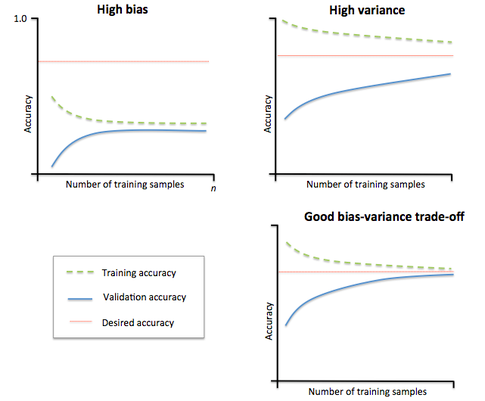

下面我们就来画一下这个learning curve~

训练集得分： 0.8207865168539327
验证集得分： 0.8114660788208472
期望得分： 0.8101456178103372
模型误差： 0.025845864606649394


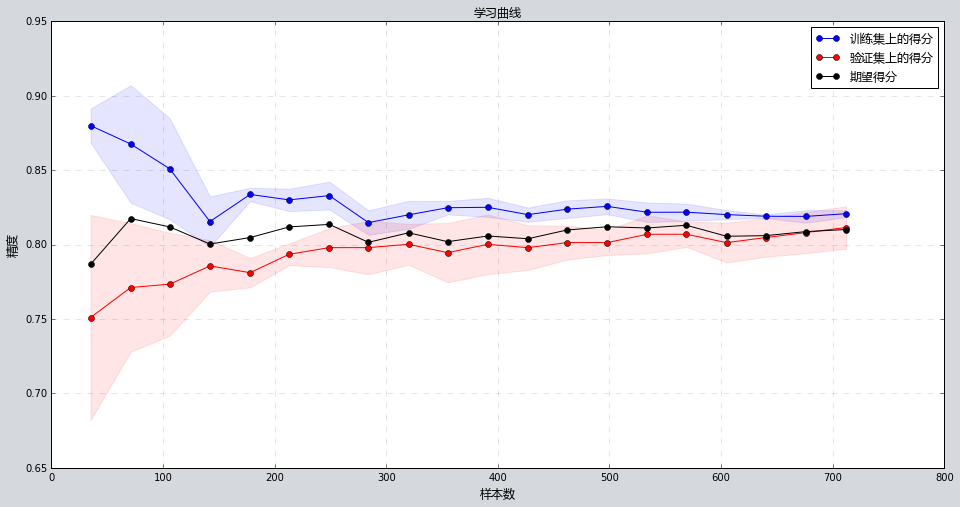

In [136]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validate_scores = learning_curve(lrSurvived, X_train, y_train,
                                                train_sizes=np.linspace(0.05, 1., 20), cv=5, n_jobs=-1,
                                                verbose=0)

# 关键参数解释：
# estimator：要验证模型的训练器
# X：输入特征
# y：目标label
# train_sizes：将输入样本数据（去掉验证集的数据）划分成多少份
# cv：将训练数据分成几折（默认为三折）用于交叉验证，也就是其中一份为验证集，n-1为训练集数据
# n_jobs：并行任务数，默认为1，与CPU核数相关

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validate_scores_mean = np.mean(validate_scores, axis=1)
validate_scores_std = np.std(validate_scores, axis=1)

midpoint = ((train_scores_mean + train_scores_std) + (validate_scores_mean - validate_scores_std)) / 2
diff = ((train_scores_mean + train_scores_std) - (validate_scores_mean - validate_scores_std))

# 绘制曲线图
plt.figure(figsize=(16, 8), facecolor='#D5D8DC')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='b', alpha=0.1)
plt.fill_between(train_sizes, validate_scores_mean - validate_scores_std,
                 validate_scores_mean + validate_scores_std, color='r', alpha=0.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='b')
plt.plot(train_sizes, validate_scores_mean, 'o-', color='r')
plt.plot(train_sizes, midpoint, 'o-', color='k')

plt.xlabel('样本数', fontproperties=font)
plt.ylabel('精度', fontproperties=font)
plt.legend(['训练集上的得分', '验证集上的得分', '期望得分'], loc='best', prop=font)
plt.title('学习曲线', fontproperties=font)
plt.grid(linestyle='dashed', alpha=0.2)
print('训练集得分：', train_scores_mean[-1])
print('验证集得分：', validate_scores_mean[-1])
print('期望得分：', midpoint[-1])
print('模型误差：', diff[-1])

In [144]:
lrSurvived.get_params(deep=True)

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

从以上曲线可以看出，模型还是处在一个比较好的状态的，泛化能力不错，没有出现过拟合，训练得分不是特别高，训练集得分和验证集得分两者最终都能够聚到一起（期望值位置）。因此，我们还可以再提高下得分，加入一些新特征~

哪应该从哪些方面进行优化呢？

* Name字段和Ticket字段（之前完全被舍弃的，现在拿过来再看看~）
* Age字段采用连续值拟合的形式，不是很准确，无法对应到生活中的，老人和小孩应收到照顾的情况
* 同时我们在训练模型时，要时刻检验模型好坏，要使用<font color='red'>交叉验证！</font>

我们可以先看下模型的系数，因模型系数是与最终判定能力正相关的！

In [137]:
pd.DataFrame({'模型特征': test_final.columns.values, '模型权重': list(lrSurvived.coef_.T)},
             columns=['模型特征', '模型权重'])

,模型特征,模型权重
0,Pclass_1,[0.5627363811668965]
1,Pclass_2,[0.20604832486285968]
2,Pclass_3,[-0.9207891431561782]
3,SibSp_0,[0.7060387067421935]
4,SibSp_1,[0.8951201376760323]
5,SibSp_2,[0.2067578876239722]
6,SibSp_3,[-0.8196401967671827]
7,SibSp_4,[-0.5167979382172815]
8,SibSp_5,[-0.09696198108228618]
9,SibSp_8,[-0.526521053101861]


我们来一一分析一下上面的系数关系：

* Pclass字段：很显然一等乘客的生还率要远大于二等/三等乘客的，且三等乘客的生还率出现了负相关拉低了整体生还率；
* SibSp字段：与之前验证的生还率随着兄弟姊妹人数增多逐一下降相对应；
* Parch字段：也差不多，出现0个生还率低，1个变高，2个又变低，3个又变高，然后就负相关，猜想是独身时也就无牵挂了，可能会选择让其他乘客活下来，而1个的话，可能是孩子，父母，有了牵挂和压力，需要活下去，2个的话，或许是父母，孩子，有了选择，又变低了，三个，可能是一孩子，两父母...
* Sex字段：是影响最大的，很明显，女性的生还率要远大于男性，而男性的存在反而拉低了这个概率！！
* Cabin字段：也是有船舱号的生还率要大于没有的，没有的就是负相关
* Embarked字段：S登船港口的生还率是负相关，C和Q则好很多
* Age字段和Fare字段：我们可以考虑离散化处理~

In [138]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
    
# 先看看全部数据的打分情况
print('整体数据打分情况：', cross_val_score(lrSurvived, X_train, y_train, cv=5).mean())

# 对样本集进行分割，进行交叉验证
split_train, split_test = train_test_split(train_final, test_size=0.3, random_state=0)

X_split_train = split_train.as_matrix()[:, :-1]
X_split_test = split_test.as_matrix()[:, :-1]
y_split_train = le.fit_transform(split_train.as_matrix()[:, -1])
y_split_test = le.fit_transform(split_test.as_matrix()[:, -1])

# 生成模型
clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X_split_train, y_split_train)

# 交叉验证
predicts = clf.predict(X_split_test)
print('三折验证集打分情况：', clf.score(X_split_test, y_split_test))

整体数据打分情况： 0.8103424833152293
三折验证集打分情况： 0.8171641791044776


In [139]:
# 筛选预测错误的数据（也就是在预测错误的数据上进一步分析，为什么会预测错误！！）

trainName.loc[predicts != y_split_test].sort_index()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,Mr,male,24.199750,0,0,330877,8.4583,No,Q
15,16,1,2,Mrs,female,55.000000,0,0,248706,16.0000,No,S
19,20,1,3,Mrs,female,27.142250,0,0,2649,7.2250,No,C
24,25,0,3,Miss,female,8.000000,3,1,349909,21.0750,No,S
33,34,0,2,Mr,male,66.000000,0,0,C.A. 24579,10.5000,No,S
40,41,0,3,Mrs,female,40.000000,1,0,7546,9.4750,No,S
50,51,0,3,Mr,male,7.000000,4,1,3101295,39.6875,No,S
59,60,0,3,Mr,male,11.000000,5,2,CA 2144,46.9000,No,S
61,62,1,1,Miss,female,38.000000,0,0,113572,80.0000,Yes,S
64,65,0,1,Mr,male,44.669500,0,0,PC 17605,27.7208,No,C


In [140]:
trainName.loc[predicts != y_split_test].sort_index().to_csv('/Users/johnnie/Desktop/bad_cases.csv')

In [141]:
trainName.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [142]:
trainName.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.028770,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.621854,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


我们先试试从以下几点来进行优化，看看分数是否会有提高：

* Age字段：一般按照生活惯例，小孩和老人会受到照顾，我们对年龄字段按阶段进行分箱
* Fare字段：船票价格，不同等级乘客的价格会不一样，可以看看是否存在关联
* SibSp字段：按照之前的分析，可将0,1 | 2,3,4 | 5,8单独分组
* Parch字段：0,1,2 | 3,5 | 4,6,9 分别放一块儿